<a href="https://colab.research.google.com/github/caiodomingues/MNIST-ANN/blob/master/ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 5 - Treinamento do Dataset MNIST

## O MNIST

O MNIST é um dataset considerado como o `hello world` das redes neurais. Todos os projetos o utilizam como exemplo: `TensorFlow, Theano, Caffe, Keras, PyTorch` etc. Para o presente projeto, faremos a implementação de uma ANN (_Artificial Neural Network_, Rede Neural Artificial - em tradução livre) utilizando o PyTorch.

--- 

O MNIST pode ser encontrado [aqui](http://yann.lecun.com/exdb/mnist/). Para este trabalho, utilizaremos o exemplo do [Kaggle](https://www.kaggle.com/ceshine/pytorch-deep-explainer-mnist-example),[AnalyticsDojo](https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb) e dos [exemplos do PyTorch no GitHub](https://github.com/pytorch/examples)

## Grupo

- Caio Domingues
- Higor Santos
- Thobias Vicente
- Vinícius Marcelo


In [1]:
# Instalamos as dependências do projeto com o pip3
# PyTorch e Vision 
!pip3 install torch torchvision

## Prosseguindo

Feito isso, podemos realizar todas as importações base para o projeto:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

Após a definição das importações, vamos definir os parâmetros e dataset da nossa rede neural.

### Parametrização da Rede Neural

É importante ressaltar que:
- Transformaremos os dados em tensores usando o módulo de transformações.
- Usaremos o `DataLoader` para criar carregadores de dados convenientes ou chamados de iteradores, o que facilita a alimentação eficiente de dados em lotes em modelos de _deep learning_.
- Criaremos também lotes dos dados configurando o parâmetro batch dentro do carregador de dados. Observe que usamos lotes de `32` para o projeto, mas é possível utilizar `64` e `128`.

In [3]:
# Tamanho padrão do batch para o nosso projeto
BATCH_SIZE = 32

# Transformações
transform = transforms.Compose(
    [transforms.ToTensor()])

## Baixando e carregando o dataset de treino
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## Baixando e carregando o dataset de teste
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Visualizando os dados

Vamos verificar o que o conjunto de dados de treino e teste possuem. Usaremos o `matplotlib` para imprimir algumas das imagens do nosso conjunto de dados.

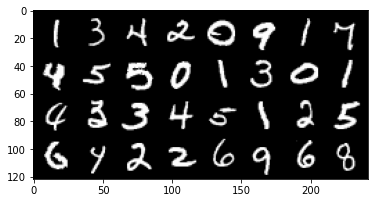

In [4]:
# Vamos importar também o NumPy e o MPLib
import matplotlib.pyplot as plt
import numpy as np

# Função p/ exibir a imagem do MNIST
def imshow(img):
    # img = img / 2 + 0.5     # Não normalizada
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Vamos pegar algumas imagens de treino aleatórias:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Visualização
imshow(torchvision.utils.make_grid(images))

In [5]:
# Vamos verificar o tamanho do batch da imagem:
for images, labels in trainloader:
    print("Tamanho do batch da imagem:", images.shape)
    print("Tamanho da label da imagem:", labels.shape)
    break

Tamanho do batch da imagem: torch.Size([32, 1, 28, 28])
Tamanho da label da imagem: torch.Size([32])


### Resultante

Desta forma, sabemos que nossas imagens são 28x28 (altura x largura), e que cada lote contém 32 amostras.

## O modelo
Usando um pipeline de estrutura de aprendizado profundo canônico, vamos construir um modelo de camada convolucional em 2D.

O `__init __ ()` define uma porção de camadas e os componentes da rede neural. Em nosso modelo, temos uma camada convolucional denotada por `nn.Conv2d(...)`. Como lidamos com um conjunto de dados de imagem em escala de cinza, precisamos apenas de um canal, portanto `in_channels = 1`. Esperamos obter uma boa representação dessa camada, portanto usamos `out_channels = 32`. O tamanho do kernel é 3 e, para o restante dos parâmetros, usamos os valores padrão que você pode encontrar [aqui](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).

Usamos também, duas camadas consecutivas (ou o que chamamos de transformações lineares) nos dados recebidos. Observe que para `D1` eu tenho uma dimensão que parece ter surgido do nada. `128` representa o tamanho que queremos como saída `(26 * 26 * 32)` e representa a dimensão dos dados recebidos. 

A camada convolucional transforma os dados de entrada em uma dimensão específica que deve ser considerada na próxima camada. O mesmo se aplica à segunda camada (`D2`), em que a dimensão da saída da camada linear anterior foi adicionada como `in_features = 128`, e `10` é apenas o tamanho da saída que também corresponde ao número de classes.

A [documentação do PyTorch](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d) explica como calcular melhor estes valores.

Após cada uma dessas camadas, também aplicamos uma função de ativação como `ReLU`. Para fins de previsão, aplicamos uma camada `softmax` à última transformação e retornamos a saída dela.


In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

### Cálculo da camada de saída

![](https://miro.medium.com/max/1400/1*gllVRO0kP4I_gshIr-OEtg.png)

In [7]:
# Vamos testar o modelo com um único batch para garantir que as dimensões de
# saída são as esperadas

model = MyModel()
for images, labels in trainloader:
    print("Tamanho do batch:", images.shape)
    out = model(images)
    print(out.shape)
    break

Tamanho do batch: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Função de perda (_loss_), otimizador (_optimizer_) e calculando a acurácia

Definimos o nosso `lr = 0.001` e um total de `5` épocas (_epochs_) p/ o treino, posteriormente atribuímos o dispositivo à uma CPU (a não ser que CUDAs estejam disponíveis, uma GPU, no caso).

A nossa escolha de otimizador vem com base em resultados de testes do CIFAR10 e um dataset de cães e gatos, bem como da própria comunidade:

Validação | Treinamento 
:-: | :-:
![Validação](https://shaoanlu.files.wordpress.com/2017/05/val_acc.png) | ![Treinamento](https://shaoanlu.files.wordpress.com/2017/05/trn_acc.png)

Perda na Validação | Perda no treinamento
:-: | :-:
![Perda na validação](https://shaoanlu.files.wordpress.com/2017/05/val_loss.png) | ![Perda no treinamento](https://shaoanlu.files.wordpress.com/2017/05/trn_loss.png)

Fontes: [Artigo sobre SGD e ADAM (gráficos)](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/), [Artigo generalista](https://ruder.io/optimizing-gradient-descent/), [Artigo generalista II](https://mlfromscratch.com/optimizers-explained/#/).

In [8]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Cálculo de acurácia
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [9]:
print("Learning Rate:", learning_rate)
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    # Hora de treinar:
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backward propagation + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        # Atualizando os parâmetros do nosso modelo
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Época: %d de %d | Loss: %.4f | Acurácia do treino: %.2f' \
          %(epoch + 1, num_epochs, train_running_loss / i, train_acc/i)) 

Learning Rate: 0.001
Época: 1 de 5 | Loss: 1.5568 | Acurácia do treino: 90.94
Época: 2 de 5 | Loss: 1.4951 | Acurácia do treino: 96.93
Época: 3 de 5 | Loss: 1.4838 | Acurácia do treino: 97.99
Época: 4 de 5 | Loss: 1.4789 | Acurácia do treino: 98.42
Época: 5 de 5 | Loss: 1.4760 | Acurácia do treino: 98.70


tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
Acurácia do teste: 24.55


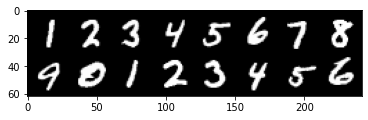

In [16]:
# Estamos prontos para testar (uma única rodada) ;)
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

imshow(torchvision.utils.make_grid(images))
print(labels.data)
print('Acurácia do teste: %.2f'%( test_acc/i))